# Assignment 2: Speech Production and Models 
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 38

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.io import wavfile
#import sounddevice as sd
from scipy.signal import firwin, filtfilt
from scipy import signal
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy.linalg import solve_toeplitz, toeplitz
import math

In [2]:
def xcorr(x, y, M):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx = (lags >= -M) & (lags <= M)
    corr = corr[idx]
    lags = lags[idx]
    return lags[len(lags) // 2:], corr[len(lags) // 2:]

# Introduction

Throughout this assignment we will use the speech data in `data["speech8"]` which is sampled at 8 kHz. `speech8` will be used both for tuning (training, optimizing) and evaluating the speech coders (evaluating on the training data is called closed test evaluation). Normally this is considered inappropriate (why?), but
we accept it here for simplicity.
You will frequently be asked to evaluate the SNR which is calculated like
$SNR = 10 \log 10 \frac{\sigma_x^2}{\sigma_q^2}$, where $X(n)$ is input speech to the coder, and $q(n) =
X(n) − \hat{X}(n)$ is the quantization error, where $\hat{X}(n)$ is the quantized speech.
Thus, calculating the SNR amounts to estimating $\sigma_x^2$, and $\sigma_q^2$.
Please note that the last part of the assignment may be the most time
consuming. There you are asked to design a forward gain and filter adaptive
DPCM coder and you are not given many instructions. Make sure you allocate
enough time for this last part!

## The Uniform Scalar Quantizer (4 pts)

In this task we implement the simplest quantizer of all: the uniform scalar
quantizer (USQ). USQs will be used frequently in this assignment.
Encoding and transmission by USQ is sometimes called Pulse Code Modulation (PCM).

In [3]:
def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d = pkl.load(f)
    return d

assignment_file = "assignment2.pkl"
data = read_assignment_file(assignment_file)

### Question 1 

Implement a uniform scalar encoder:

```python
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples, 
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate), 
    xmax and m define the range of the quantizer from m-xmax to m+xmax, 
       so that the width of each quantization interval is ∆ = 2 × xmax/L, 
           where L is the number of quantization intervals and corresponding reconstruction values. 
       m defines the mean (or offset) of the quantizer reconstruction levels. 
    
    The function should return the index of the chosen quantization level.
    """
    return idx
```

Setting m = 0 defines a “midrise” quantizer, and m = $\frac{\Delta}{2}$ gives a "midtread" quantizer (see the course book sec. 7.2).


Implement also the corresponding decoder function
```python
def sq_dec(idx, n_bits, xmax, m)
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """
    
    return outq
```
The USQ is a highly structured quantizer. The encoder can be imple-
mented essentially by only a scalar division (no multiplications, compar-
isons or loops are needed), making the computational complexity inde-
pendent of the bitrate. Make sure your encoder has a computational
complexity independent of the bitrate!


### Question 2 (4 pts)

Run the encoder and decoder on a ramp signal `x=np.linspace(-6,6,1201)`. Use a `2-bit` quantizer with $x_{max} = 4$. 

Plot the quantizer output as a function of the input. 

Make sure the output levels are exactly where you expect them to be.

Use a quantizer mean $m=0$. Do a similar plot with $m=1.5$.

In [44]:
def sq_enc(xin, n_bits, xmax, m):
    
    L = 2 ** n_bits
    delta = 2 * xmax / L

    xl = m - xmax + delta
    xr = m + xmax - delta
    idx = np.zeros(len(xin))

    for i in range(len(xin)):
        if xin[i] < xl:
            idx[i] = 0
        elif xin[i] >= xr:
            idx[i] = L - 1
        else:
            idx[i] = np.floor((xin[i] - m + xmax) / delta)
        
    return idx

In [5]:
def sq_dec(idx, n_bits, xmax, m):
    
    L = 2 ** n_bits
    delta = 2 * xmax / L

    xmin_hat = m - (L - 1) * delta / 2

    xout = idx * delta + xmin_hat
    
    return xout

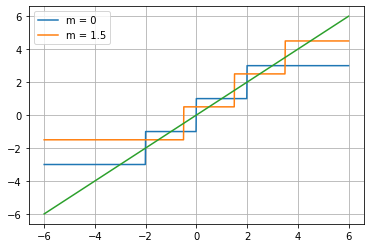

In [6]:
xin = np.linspace(-6, 6, 1021)
n_bits = 2
xmax = 4
m1 = 0
m2 = 1.5
idx1 = sq_enc(xin, n_bits, xmax, m1)
idx2 = sq_enc(xin, n_bits, xmax, m2)
xout1 = sq_dec(idx1, n_bits, xmax, m1)
xout2 = sq_dec(idx2, n_bits, xmax, m2)

plt.plot(xin, xout1, label = 'm = 0')
plt.plot(xin, xout2, label = 'm = 1.5')
plt.plot(xin,xin)
plt.legend()
plt.grid()

In [4]:
def quantizer(xin, n_bits, xmax, m):
    
    L = 2 ** n_bits
    delta = 2 * xmax / L

    xl = m - xmax + delta
    xr = m + xmax - delta

    xmin_hat = m - (L - 1) * delta / 2
    xmax_hat = xmin_hat + (L - 1) * delta

    xout = np.zeros(len(xin))

    for i in range(len(xin)):
        if xin[i] < xl:
            xout[i] = xmin_hat
        elif xin[i] >= xr:
            xout[i] = xmax_hat
        else:
            xout[i] = np.floor((xin[i] - m + xmax) / delta) * delta + xmin_hat
    
    return xout

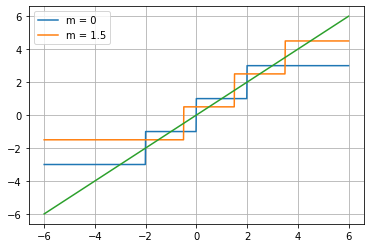

In [46]:
xin = np.linspace(-6, 6, 1021)
n_bits = 2
xmax = 4
m1 = 0
m2 = 1.5

xout1 = quantizer(xin, n_bits, xmax, m1)
xout2 = quantizer(xin, n_bits, xmax, m2)

plt.plot(xin, xout1, label = 'm = 0')
plt.plot(xin, xout2, label = 'm = 1.5')
plt.plot(xin,xin)
plt.legend()
plt.grid()

## Parametric Coding of Speech (23 pts)

In this task we complete our design of the vocoder from assignment 1.
Note that the speech used in this assignment is different from assignment 1 and if
your vocoder analysis is not robust you may have to retune the analysis for this
assignment.
You are encouraged to use your own vocoder. 
However, it must produce a quality that is at least as high as our vocoder provided to you.
If not, then you have to get aquainted with our vocoder, and use that in the following.
In practice, a speech coder must operate on a frame-by-frame basis, and transmit compressed data as quickly as possible in order to keep the delay short.
However, you may have implemented your vocoder in an off-line fashion (the pitch estimator is easier to implement like that for example). 
This is acceptable also here.

In [5]:
def analysis_E_ZC_V_A_P(x, alen, ulen, M):
    N = len(x)
    naf = np.floor((N - alen + ulen) / ulen)
    naf = int(naf)
    n1 = 1
    n2 = alen

    # Initialization
    E = np.zeros(naf)           # Frame Energy
    ZC = np.zeros(naf)          # Zero Crossings
    V = np.zeros(naf)           # Voiced / Unvoiced
    A = np.zeros((naf, M + 1))  # LP Coefficients, M: Prediction Order
    P = np.zeros(naf)           # Pitch Period

    for n in range(0, naf):

        xf0 = x[n1 - 1: n2]
        xf = np.int64(xf0)
        e = np.power(xf, 2)
        E[n] = np.sum(e) / alen

        count_zc = 0            # number of zero crossings

        for i in range(1, alen):

            if xf[i - 1] * xf[i] < 0:
                count_zc = count_zc + 1

        ZC[n] = count_zc / alen

        if ZC[n] < 0.28:

            V[n] = 1  # Voiced

        else:

            V[n] = 0  # Unvoiced

        _, r = xcorr(xf, xf, M)
        a = np.concatenate([np.ones(1), solve_toeplitz(r[: -1], -r[1:])]).reshape(-1, 1)
        A[n] = a.T

        corr = signal.correlate(xf, xf, mode='full')
        corr = corr[(len(corr) + 1) // 2 - 1:]
        peaks, _ = signal.find_peaks(corr, 3)
        idx = 0

        
        for j in range(len(peaks)):

            if corr[peaks[j]] > corr[peaks[idx]]:
                idx = j

        P[n] = peaks[idx]
        

        # P[n] = peaks[idx]

        n1 = n1 + ulen
        n2 = n2 + ulen

    return E, ZC, V, A, P

In [6]:
def synthesis(E, ZC, V, A, P, ulen):
    
    A = np.float32(A)
    n_frames = A.shape[0]

    # Create a noise excitation:
    nexc = np.random.rand(n_frames * ulen)
    nexc = np.float32(nexc)

    n1 = 0
    Z = np.array([])
    Z = np.float32(Z)

    s = np.zeros(n_frames * ulen)
    s = np.float32(s)

    E2 = np.zeros(n_frames)
    E2 = np.float32(E2)

    idx = 0

    for n in range(0, n_frames):

        # Filter the excitation through the production (vocal tract) filter:      
        # Low pass filter
        if V[n] == 1:

            while idx < P[n]:
                idx = idx + 1

            cp = P[n]
            cp = int(cp)
            pexc = np.zeros(n_frames * ulen)
            pexc = np.float32(pexc)
            pexc[0:: cp] = 1

            if Z.shape[0] == 0:

                s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen])
                Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x=pexc[n1: n1 + ulen])

            else:

                s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], pexc[n1: n1 + ulen], zi=Z)

        else:

            if Z.shape[0] == 0:

                s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], nexc[n1: n1 + ulen])
                Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x=nexc[n1: n1 + ulen])

            else:
                
                s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], nexc[n1: n1 + ulen], zi=Z)

        e = np.power(s[n1: n1 + ulen], 2)
        E2[n] = np.sum(e) / ulen
        s[n1: n1 + ulen] = s[n1: n1 + ulen] * math.sqrt(E[n] / E2[n])
        n1 = n1 + ulen
        idx = 0

    return s

In [7]:
x = data['speech8']
x = x.flatten()
alen = 256
ulen = 128
M = 10
E, ZC, V, A, P = analysis_E_ZC_V_A_P(x, alen, ulen, M)

### Quantizing the Gain (8 pts)

#### Question 1 (1 pts)

Provide a plot of the histogram of the gain parameter.
Indicate in the plot the range of the quantizer, i.e., mark the outer boundaries $m\pm xmax$ (also mark m).
Note that the pdf has a non-zero mean.

#### Question 2 (2 pts)

Run the vocoder with a uniform scalar gain quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.

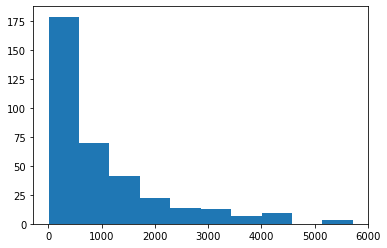

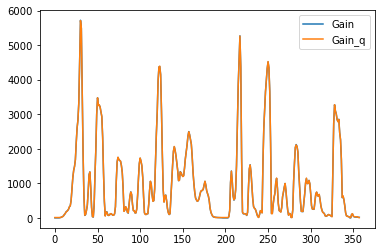

3.6763602924631855 5719.361388083464 2861.5188741879633 2857.8425138955004


In [35]:
gain = np.sqrt(E)
plt.hist(gain)
plt.show()
plt.plot(gain, label = 'Gain')
min = np.min(gain)
max = np.max(gain)

n_bits = 8
m = (max + min) / 2
xmax = (max - min) / 2

gain_q = quantizer(gain, n_bits, xmax, m)
plt.plot(gain_q, label = 'Gain_q')
plt.legend()
plt.show()
print(min, max, m, xmax)

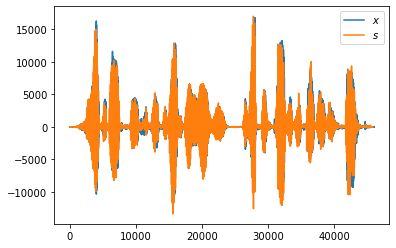

In [13]:
E_q = gain_q ** 2
s = synthesis(E_q, ZC, V, A, P, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(s, label="$s$")
ax.legend()
#sd.play(s, 8000)

#### Question 3 (1 pts)

Take the logarithm of the gain parameter prior to quantization (does not matter which base).
Provide a plot of the histogram of the gain parameter in the log-domain.
Indicate the range of this quantizer as above.

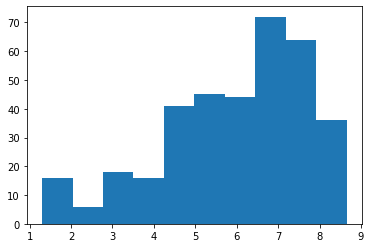

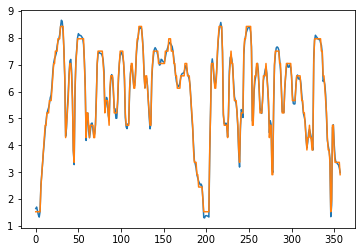

1.3019232117861037 8.651612432701073 4.9767678222435885 3.674844610457485


In [21]:
gain = np.sqrt(E)
gain1 = np.log(gain)
plt.hist(gain1)
plt.show()
plt.plot(gain1)
min = np.min(gain1)
max = np.max(gain1)

n_bits = 4
m = (max + min) / 2
xmax = (max - min) / 2

gain_q = quantizer(gain1, n_bits, xmax, m)
plt.plot(gain_q)
plt.show()
print(min, max, m, xmax)

#### Question 4 (2 pts)

Run the vocoder with a uniform scalar log-gain quantizer according to the design above.
Find the rate at which you cannot hear the quantization distortion.
Make sure to modify the decoder accordingly (apply the exp function to the quantized log-gain).

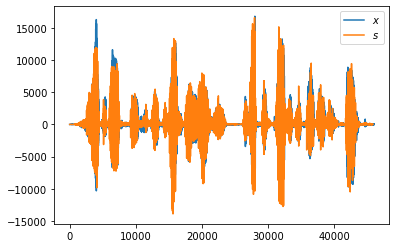

In [22]:
gain_q = np.exp(gain_q)
E_q = gain_q ** 2
s = synthesis(E_q, ZC, V, A, P, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(s, label="$s$")
ax.legend()
#sd.play(s, 8000)

#### Question 5 (2 pts)

Which is better: gain quantization in linear or log domain?

### Quantizing the Pitch and Voiced/Unvoiced Decision (2 pts)

#### Question 1 (2 pts)

Come up with an efficient way to encode the pitch and voiced/unvoiced decision.

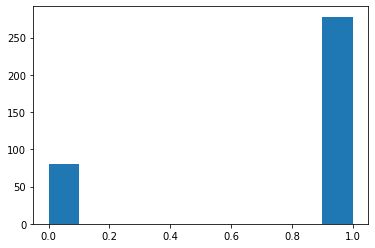

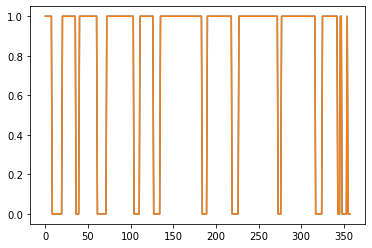

In [10]:
plt.hist(V)
plt.show()
plt.plot(V)
min = np.min(V)
max = np.max(V)

n_bits = 1
m = (max + min) / 2
xmax = (max - min) / 2

#V_q = quantizer(V, n_bits, xmax, m)
V_q = V
plt.plot(V_q)
plt.show()

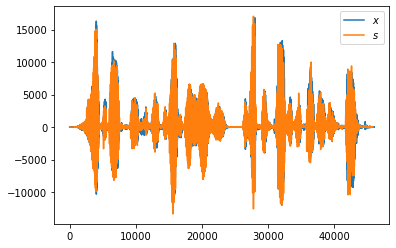

In [11]:
s = synthesis(E, ZC, V_q, A, P, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(s, label="$s$")
ax.legend()
#sd.play(s, 8000)

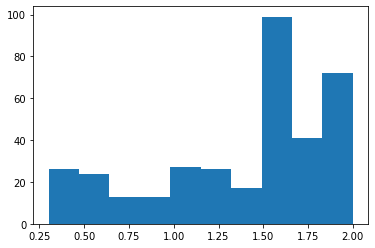

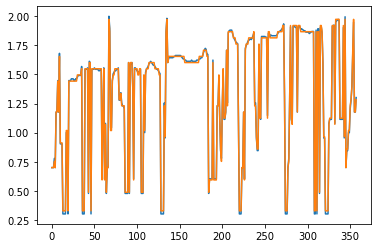

In [12]:
#P = np.float64(P)
P1 = np.log10(P)
plt.hist(P1)
plt.show()
plt.plot(P1)
min = np.min(P1)
max = np.max(P1)

n_bits = 5
m = (max + min) / 2
xmax = (max - min) / 2

P_q = quantizer(P1, n_bits, xmax, m)
plt.plot(P_q)
plt.show()

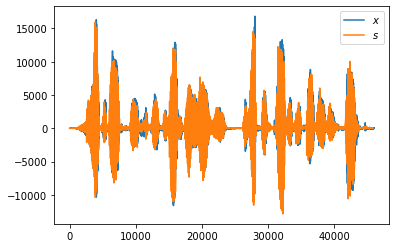

In [13]:
#P_q = np.float64(P_q)
P_q = np.power(10, P_q)
s = synthesis(E, ZC, V, A, P_q, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(s, label="$s$")
ax.legend()
#sd.play(s, 8000)

### Quantizing the LP parameters (4 pts)

#### Question 1 (4 pts)

For the quantization of LP parameters, we will use a vector quantizer (VQ).
You do not need to optimize (train) the VQs; that has been done for you, and
the codebooks can be found in the MATLAB variables lsfCB1 and lsfCB2 in
the file assignment2.mat.
The codebooks constitute a multistage VQ. 
`lsfCB1` is a 10 bit VQ optimized on 10 dimensional LSF vectors. 
`lsfCB2` is a 10 bit second stage residual codebook. 

What you need to do is to program an encoding function and a corresponding decoding function for a multistage VQ. 
A suitable calling syntax for these functions can be

```python
def encodefilter(A, cb1, cb2):
    return codeA
```

```python
def decodefilter(codeA, cb1, cb2):
    return Aq
```

Here A is a matrix with filter coefficients stored row-wise, and codeA is a two-column matrix with the corresponding code indices, stored row-wise.

Notes:

1. To convert between polynomial (a-) coefficients and LSFs see `poly2lsf` and `lsf2poly`. You migh require toolboxes such as https://pyspectrum.readthedocs.io/en/latest/install.html

2. `poly2lsf` requires the polynomial coefficients to correspond to a minimum phase whitening filter. 
This is guaranteed by the autocorrelation LP analysis.
`lsf2poly` requires that the LSFs correspond to a minimum phase whitening filter.
The multistage VQ can output LSFs that do not satisfy this.
As a precaution simply sort the LSFs prior to calling `lsf2poly`.
Also check so they are between 0 and $\pi$.

In [14]:
def lsf2poly(lsf):
    """Convert line spectral frequencies to prediction filter coefficients

    returns a vector a containing the prediction filter coefficients from a vector lsf of line spectral frequencies.

    .. doctest::

        >>> from spectrum import lsf2poly
        >>> lsf = [0.7842 ,   1.5605  ,  1.8776 ,   1.8984,    2.3593]
        >>> a = lsf2poly(lsf)

    # array([  1.00000000e+00,   6.14837835e-01,   9.89884967e-01,
    # 9.31594056e-05,   3.13713832e-03,  -8.12002261e-03 ])

    .. seealso:: poly2lsf, rc2poly, ac2poly, rc2is
    """
    #   Reference: A.M. Kondoz, "Digital Speech: Coding for Low Bit Rate Communications
    #   Systems" John Wiley & Sons 1994 ,Chapter 4

    # Line spectral frequencies must be real.

    lsf = np.array(lsf)

    if np.max(lsf) > np.pi or np.min(lsf) < 0:
        raise ValueError('Line spectral frequencies must be between 0 and pi.')

    p = len(lsf) # model order

    # Form zeros using the LSFs and unit amplitudes
    z  = np.exp(1.j * lsf)

    # Separate the zeros to those belonging to P and Q
    rQ = z[0::2]
    rP = z[1::2]

    # Include the conjugates as well
    rQ = np.concatenate((rQ, rQ.conjugate()))
    rP = np.concatenate((rP, rP.conjugate()))

    # Form the polynomials P and Q, note that these should be real
    Q  = np.poly(rQ)
    P  = np.poly(rP)

    # Form the sum and difference filters by including known roots at z = 1 and
    # z = -1

    if p%2:
        # Odd order: z = +1 and z = -1 are roots of the difference filter, P1(z)
        P1 = np.convolve(P, [1, 0, -1])
        Q1 = Q
    else:
        # Even order: z = -1 is a root of the sum filter, Q1(z) and z = 1 is a
        # root of the difference filter, P1(z)
        P1 = np.convolve(P, [1, -1])
        Q1 = np.convolve(Q, [1,  1])

    # Prediction polynomial is formed by averaging P1 and Q1

    a = .5 * (P1+Q1)
    return a[0:-1:1] # do not return last element

In [15]:
from scipy.signal import deconvolve

In [16]:
def poly2lsf(a):
    """Prediction polynomial to line spectral frequencies.

    converts the prediction polynomial specified by A,
    into the corresponding line spectral frequencies, LSF.
    normalizes the prediction polynomial by A(1).

    .. doctest::

        >>> from spectrum import poly2lsf
        >>> a = [1.0000,  0.6149, 0.9899, 0.0000 ,0.0031, -0.0082]
        >>> lsf = poly2lsf(a)
        >>> lsf =  array([0.7842, 1.5605, 1.8776, 1.8984, 2.3593])

    .. seealso:: lsf2poly, poly2rc, poly2qc, rc2is
    """

    #Line spectral frequencies are not defined for complex polynomials.

    # Normalize the polynomial

    a = np.array(a)
    if a[0] != 1:
        a/=a[0]


    # Form the sum and differnce filters

    p  = len(a)-1   # The leading one in the polynomial is not used
    a1 = np.concatenate((a, np.array([0])))
    a2 = a1[-1::-1]
    P1 = a1 - a2        # Difference filter
    Q1 = a1 + a2        # Sum Filter

    # If order is even, remove the known root at z = 1 for P1 and z = -1 for Q1
    # If odd, remove both the roots from P1

    if p%2: # Odd order
        P, r = deconvolve(P1,[1, 0 ,-1])
        Q = Q1
    else:          # Even order
        P, r = deconvolve(P1, [1, -1])
        Q, r = deconvolve(Q1, [1,  1])

    rP  = np.roots(P)
    rQ  = np.roots(Q)

    aP  = np.angle(rP[1::2])
    aQ  = np.angle(rQ[1::2])

    lsf = sorted(np.concatenate((-aP,-aQ)))

    return lsf

In [17]:
def encodefilter(A, cb1, cb2):
    
    codeA = np.zeros((len(A), 2), int)
    
    for i in range(len(A)):
        
        lsf = poly2lsf(A[i])
        
        dist1 = np.zeros(len(cb1))
        dist2 = np.zeros(len(cb2))
        
        for j in range(len(cb1)):
            
            dist1[j] = np.linalg.norm(lsf-cb1[j])
            
        idx1 = np.min(np.where(dist1 == np.min(dist1))[0])

        d = lsf - cb1[idx1]
        
        for k in range(len(cb2)):
            
            dist2[k] = np.linalg.norm(d-cb2[k])
        
        idx2 = np.min(np.where(dist2 == np.min(dist2))[0])

        idx1 = idx1.astype(int)
        idx2 = idx2.astype(int)
        codeA[i] = [idx1, idx2]
        
    return codeA

In [18]:
def decodefilter(codeA, cb1, cb2):
    
    Aq = np.zeros((len(codeA), cb1.shape[1] + 1))
    
    for i in range(len(codeA)):
        
        lsf = cb1[codeA[i, 0]] + cb2[codeA[i, 1]]
        Aq[i] = lsf2poly(sorted(lsf))
        
    return Aq

In [20]:
cb1 = data['lsfCB1']
cb2 = data['lsfCB2']
codeA = encodefilter(A, cb1, cb2)
A_q = decodefilter(codeA, cb1, cb2)

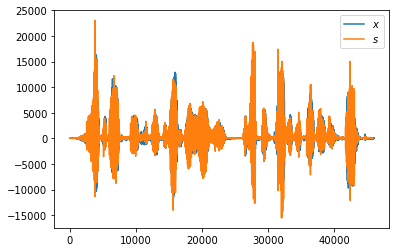

In [63]:
s = synthesis(E, ZC, V, A_q, P, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(s, label="$s$")
ax.legend()
#sd.play(s, 8000)

### Optimizing the Bit Allocation (9 pts)

Here you experiment a little with the number of bits to use for each parameter.
Since you are provided with the LSF codebooks, you cannot experiment with the number of bits spent on LP parameter quantization.
LP quantization contributes a lot to the total number of bits, and the choice of LSF codebook size
vs. performance is crucial in vocoder design, but here we keep the LSF codebook
size fixed.
Find a bit allocation (i.e. the number of bits to use in each quantizer) for the gain, pitch, voiced/unvoiced quantizers, such that the quality is the same as when these parameters are unquantized (the effect of the LP parameter quantization is always present).

#### Question 1 (2 pts)

Evaluate the SNR for your design above.

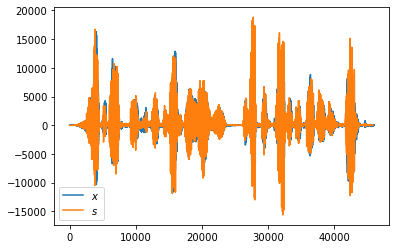

In [23]:
s = synthesis(E_q, ZC, V_q, A_q, P_q, ulen)
_, ax = plt.subplots(1, 1)
ax.plot(x, label="$x$")
ax.plot(s, label="$s$")
ax.legend()
#sd.play(s, 8000)

In [24]:
q = x[0: len(s)] - s
varx = np.var(x)
varq = np.var(q)
SNR = 10 * np.log10(varx / varq)
print(SNR)

-3.116999259952507


#### Question 2 (3 pts)

What number of bits do you suggest for the pitch? For the gain? For the
voiced/unvoiced decision?

pitch: 5 bits
gain: 4bits
voiced/unvoiced decision: 1 bit

#### Question 3 (2 pts)

What is the rate in bits per sample of your vocoder with the bit allocation
suggested above? In bits per second?

(5 + 4 + 1 + 10 + 10) / 128 = 0.2344 bits/sample. Here, the frame length ulen = 128.
(5 + 4 + 1 + 10 + 10) / 128 * 8000 = 1.875 kbits/s 

#### Question 4 (2 pts)

Does it make sense to evaluate SNR here? Why or why not?

No.

## Speech Waveform Quantization (8 pts +2)

#### Uniform Scalar Quantization of Speech

We will in the following design our quantizers using $x_{max} = \sigma_Xk$ , where $\sigma_X$
is the variance of speech and k is an experimentally tuned parameter (here it is tuned to maximize SNR). 

`k` is rate dependent and the SNR optimal `k` for rates 1 to 16 are
```python
l=[0.95, 2.1, ?, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2,
11.15, 11.15]
```

The optimal (in terms of SNR) value for $R = 3$ is to be found experimentally.
Run the quantizer with different values of k, and measure the SNR, to find the optimal choice.

##### Question 1 (2 pts)

Evaluate the optimal `k` for $R = 3$.

In [82]:
sigmax = np.sqrt(varx)
k = np.linspace(2.15, 4.9, 276)
n_bits = 3
m = 0
SNR = np.zeros(len(k))

for i in range(len(k)):
    
    xmax = sigmax * k[i]
    x_q = quantizer(x, n_bits, xmax, m)
    SNR[i] = 10 * np.log10(np.var(x) / np.var(x - x_q))
    
i_opt = np.where(SNR == np.max(SNR))
k3_opt = k[i_opt][0]

print(i_opt[0])
print(k3_opt)
print(k.shape)

[131]
3.46
(276,)


##### Question 2 (2 pts)

Run the quantizer at rates [16, 15, 14, . . ., 2, 1], and evaluate the SNR
for each rate.
Provide a plot of the SNR as a function of rate.

##### Question 3 (2 pts)

Provide a graph of the theoretical SNR in the same plot as the experimental SNR plot.
For the theoretical SNR, assume that the number of quantization levels is high, and that overload is negligible.

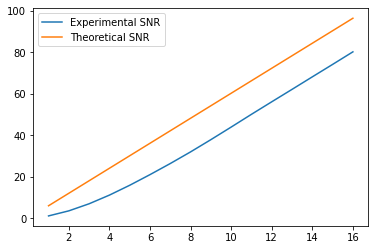

In [84]:
l = [0.95, 2.1, k3_opt, 4.95, 6.3, 7.65, 8.85, 9.95, 10.6, 11.0, 11.1, 11.2, 11.15, 11.2, 11.15, 11.15]
n_bits = np.linspace(1, 16, 16)
sigmax = np.sqrt(varx)
m = 0
SNR = np.zeros(len(l))

for i in range(len(n_bits)):
    
    xmax = sigmax * l[i]
    x_q = quantizer(x, n_bits[i], xmax, m)
    SNR[i] = 10 * np.log10(np.var(x) / np.var(x - x_q))

SNR_t = 10 * np.log10(2 ** (2 * n_bits))
plt.plot(n_bits, SNR, label = 'Experimental SNR')
plt.plot(n_bits, SNR_t, label = 'Theoretical SNR')
plt.legend()
plt.show()

##### Question 4 (1 pts)

At what rate can you not tell the difference between the original and the quantized signal?

31.966771895587986


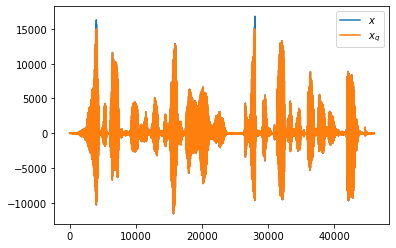

In [85]:
i = 7
sigmax = np.sqrt(varx)
m = 0
xmax = sigmax * l[i]
x_q = quantizer(x, n_bits[i], xmax, m)
SNR = 10 * np.log10(np.var(x) / np.var(x - x_q))
#sd.play(x, 8000)
#sd.play(x_q, 8000)
print(SNR)
plt.plot(x, label="$x$")
plt.plot(x_q, label="$x_q$")
plt.legend()

##### Question 5 (1 pts)

Listen to the quantization error signal, $q(n)$. 
How would you characterize $q(n)$ for a system operating at rate $R = 1$.
Increase the rate (up to $R \approx 12$) and describe how the character of $q(n)$ changes.

In [32]:
i = 0
sigmax = np.sqrt(varx)
m = 0
xmax = sigmax * l[i]
x_q = quantizer(x, n_bits[i], xmax, m)
q = x - x_q
covar = np.cov(x, x_q, bias = True)
#sd.play(q, 8000)
print(covar)

[[2281352.98112153  518260.05145876]
 [ 518260.05145876  514183.65296555]]


In [33]:
i = 5
sigmax = np.sqrt(varx)
m = 0
xmax = sigmax * l[i]
x_q = quantizer(x, n_bits[i], xmax, m)
q = x - x_q
covar = np.cov(x, x_q, bias = True)
#sd.play(q, 8000)
print(covar)

[[2281352.98112153 2262565.30629489]
 [2262565.30629489 2261832.9847502 ]]


In [34]:
i = 11
sigmax = np.sqrt(varx)
m = 0
xmax = sigmax * l[i]
x_q = quantizer(x, n_bits[i], xmax, m)
q = x - x_q
covar = np.cov(x, x_q, bias = True)
#sd.play(q, 8000)
print(covar)

[[2281352.98112153 2281308.56200496]
 [2281308.56200496 2281269.75158052]]


##### Question 6 (OPTIONAL 2 pts)

Is it advantageous to have a reconstruction level in the origin for low rates?
Compare (by listening) midrise and midtread quantizers at low bit rates.

6.981235912271807
8.935190893506633


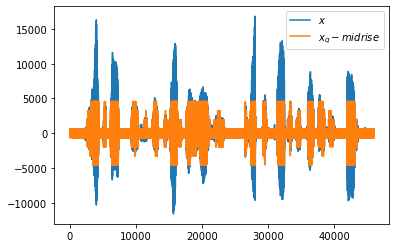

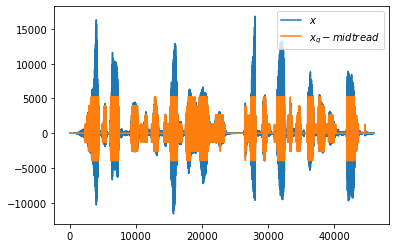

In [36]:
i = 2
sigmax = np.sqrt(varx)
xmax = sigmax * l[i]
L = 2 ** n_bits[i]
delta = 2 * xmax / L
m1 = 0
m2 = delta / 2
x_q1 = quantizer(x, n_bits[i], xmax, m1)
x_q2 = quantizer(x, n_bits[i], xmax, m2)
SNR1 = 10 * np.log10(np.var(x) / np.var(x - x_q1))
SNR2 = 10 * np.log10(np.var(x) / np.var(x - x_q2))
#sd.play(x_q1, 8000)
#sd.play(x_q2, 8000)
print(SNR1)
print(SNR2)
plt.plot(x, label="$x$")
plt.plot(x_q1, label="$x_{q}-midrise$")
plt.legend()
plt.show()
plt.plot(x, label="$x$")
plt.plot(x_q2, label="$x_{q}-midtread$")
plt.legend()
plt.show()

## Adaptive Open-Loop DPCM (13 pts)
<img src="./openloopdcm.png" alt="alt text" width="800"/>

In this section we will study open-loop Differential Pulse Code Modulation (DPCM).
Open loop DPCM can be viewed as pre-filtering, quantization, and post-filtering, see Figure 1 (the adaptation
mechanism is not shown). 
It is called open loop because the quantizer is not part of the prediction loop.

We will want to adapt both the LP coefficients and the gain in a forward fashion.
See the vocoder section for hints on how to forward adapt those.
In general the structure of open loop DPCM is similar to the vocoder structure with
one important difference: vocoders create an artificial replica of the prediction
error signal $d(n)$ (by estimating voiced/unvoiced, the pitch, energy), whereas
open loop DPCM coders quantize each sample of the prediction error signal
and thus try to preserve the original waveform. 

We recommend that you reuse as much as possible of the code from the vocoder.

#### Question 1 (4 pts)
You are not given many guidelines here. Give it your best shot and make
sure you can motivate your choice of for example
- analysis frame length,
- update length (to keep things simple make analysis and update lengths
equal, i.e., no overlapping analysis frames),
- window function (for the analysis of certain parameters),
- number of bits to quantize the gain,
- number of bits to quantize the residual,
Use the VQ as before to quantize the LP parameters (thus, you need not
decide prediction order!).

Design the PCM quantizer for the prediction error d(n) according to
$x_{max} = k \sigma_d$ . 
Optimize k for $R = 3$ (R meaning the rate of the residual quantizer), by experimenting, so that it sounds good, i.e., do not optimize SNR theoretically.

In [58]:
def encoder(x, alen, ulen, M):
    N = len(x)
    naf = np.floor((N - alen + ulen) / ulen)
    naf = int(naf)
    n1 = 1
    n2 = alen

    # Initialization
    E = np.zeros(naf)           # Frame Energy
    A = np.zeros((naf, M + 1))  # LP Coefficients, M: Prediction Order
    d = np.zeros(naf)

    for n in range(0, naf):

        # xf0 = x[n1 - 1: n2]
        xf0 = x[n1 - 1: n2] * signal.windows.hann(alen)
        
        xf = np.int64(xf0)
        e = np.power(xf, 2)
        E[n] = np.sum(e) / alen

        _, r = xcorr(xf, xf, M)
        a = np.concatenate([np.ones(1), solve_toeplitz(r[: -1], -r[1:])]).reshape(-1, 1)
        A[n] = a.T

        n1 = n1 + ulen
        n2 = n2 + ulen
        
    A = np.float32(A)
    n_frames = A.shape[0]
    
    n1 = 0
    Z = np.array([])
    Z = np.float32(Z)
    
    s = np.zeros(n_frames * ulen)
    s = np.float32(s)
    
    d = np.zeros(n_frames * ulen)
    d = np.float32(d)

    E2 = np.zeros(n_frames)
    E2 = np.float32(E2)
    
    g = np.zeros(n_frames)
    g = np.float32(g)

    for n in range(0, n_frames):
        
        xf1 = x[n1: n1 + ulen]
        xE = np.power(xf, 2)
        g[n] = np.sqrt(np.sum(xE) / alen)
        #xf1 = x[n1: n1 + ulen] * signal.windows.hann(alen)
        #H = np.zeros(len(A[n]) + 1)
        #H[0] = 1
        #H[1:] = H[1:] - A[n]

        '''
        if Z.shape[0] == 0:

            #s[n1: n1 + ulen] = signal.lfilter(H, np.array([1]), xf1)
            #Z = signal.lfiltic(H, np.array([1]), s[n1: n1 + ulen], x = xf1)
            s[n1: n1 + ulen] = signal.lfilter(A[n], np.array([1]), xf1)
            Z = signal.lfiltic(A[n], np.array([1]), s[n1: n1 + ulen], x = xf1)

        else:

            #s[n1: n1 + ulen], Z = signal.lfilter(H, np.array([1]), xf1, zi = Z)
            s[n1: n1 + ulen], Z = signal.lfilter(A[n], np.array([1]), xf1, zi = Z)
        '''
        s[n1: n1 + ulen] = signal.lfilter(A[n], np.array([1]), xf1)
        #e = np.power(s[n1: n1 + ulen], 2)
        #E2[n] = np.sum(e) / ulen
        s[n1: n1 + ulen] = s[n1: n1 + ulen] / g[n]
        n1 = n1 + ulen

    
    return A, s, g

In [59]:
x = data['speech8']
x = x.flatten()
alen = 256
ulen = 256
M = 10
A, d, g = encoder(x, alen, ulen, M)

32.88575329768592


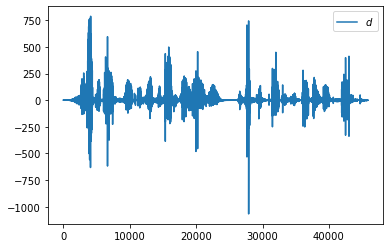

In [61]:
SNR = 10 * np.log10(np.var(x) / np.var(d))
#sd.play(x, 8000)
#sd.play(d, 8000)
print(SNR)
#plt.plot(x, label="$x$")
plt.plot(d, label="$d$")
plt.legend()

In [62]:
#gain = np.sqrt(E)
#gain1 = np.log10(gain)
gain1 = np.log10(g)
min = np.min(gain1)
max = np.max(gain1)

n_bits = 4
m = (max + min) / 2
xmax = (max - min) / 2

gain_q = quantizer(gain1, n_bits, xmax, m)
gain_q = np.power(10, gain_q)
#E_q = gain_q ** 2

In [63]:
cb1 = data['lsfCB1']
cb2 = data['lsfCB2']
codeA = encodefilter(A, cb1, cb2)
A_q = decodefilter(codeA, cb1, cb2)

3.378531466710421
[[1173.86240404  485.99607867]
 [ 485.99607867  337.34729238]]


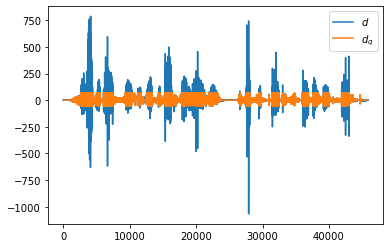

In [64]:
vard = np.var(d)
sigmad = np.sqrt(vard)
k = 2
n_bits = 3
xmax = sigmad * k

L = 2 ** n_bits
delta = 2 * xmax / L
m = delta / 2

d_q = quantizer(d, n_bits, xmax, m)
q = d - d_q

SNR_PCM = 10 * np.log10(np.var(d) / np.var(q))
print(SNR_PCM)
covar = np.cov(d, d_q, bias = True)
print(covar)
#sd.play(d, 8000)
#sd.play(d_q, 8000)
plt.plot(d, label="$d$")
plt.plot(d_q, label="$d_q$")
#plt.plot(q, label="$q$")
plt.legend()

#### Question 2 (1 pts)

Run your system at R = 3. 
How would you characterize the reconstructed speech? What does the quantization error sound like?


In [69]:
def decoder(g, A, d, ulen):

    A = np.float32(A)
    n_frames = A.shape[0]


    n1 = 0
    Z = np.array([])
    Z = np.float32(Z)
    
    s = np.zeros(n_frames * ulen)
    s = np.float32(s)

    E2 = np.zeros(n_frames)
    E2 = np.float32(E2)

    for n in range(0, n_frames):
        
        #H = np.zeros(len(A[n]) + 1)
        #H[0] = 1
        #H[1:] = H[1:] - A[n]
        '''
        if Z.shape[0] == 0:
            
            #s[n1: n1 + ulen] = signal.lfilter(np.array([1]), H, d[n1: n1 + ulen])
            #Z = signal.lfiltic(np.array([1]), H, s[n1: n1 + ulen], x = d[n1: n1 + ulen])
            s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], d[n1: n1 + ulen])
            Z = signal.lfiltic(np.array([1]), A[n], s[n1: n1 + ulen], x = d[n1: n1 + ulen])
            
        else:
            
            #s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), H, d[n1: n1 + ulen], zi=Z)
            s[n1: n1 + ulen], Z = signal.lfilter(np.array([1]), A[n], d[n1: n1 + ulen], zi=Z)
        '''
        
        d[n1: n1 + ulen] = d[n1: n1 + ulen] * g[n]
        s[n1: n1 + ulen] = signal.lfilter(np.array([1]), A[n], d[n1: n1 + ulen])
        #e = np.power(s[n1: n1 + ulen], 2)
        #E2[n] = np.sum(e) / ulen
        #s[n1: n1 + ulen] = s[n1: n1 + ulen] * g[n]
        
        n1 = n1 + ulen
        

    return s

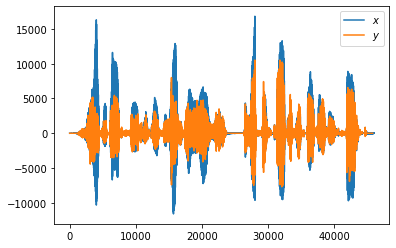

In [70]:
y = decoder(gain_q, A_q, d_q, ulen)
plt.plot(x, label="$x$")
plt.plot(y, label="$y$")
plt.legend()
plt.show()

#### Question 3 (2 pts)

What shape does the quantization error spectrum have? 
Plot a DFT based spectrum of the error for a voiced frame. 
What does theory say?

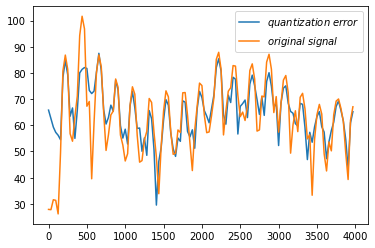

In [73]:
S = 10000  # Start of the frame
N = 256  # Length of the frame
fs = 8000

df = fs / N
ff = np.arange(0, fs // 2, df)

xf = y[S - 1: S + N - 1] * signal.windows.hann(N)
xxf = x[S - 1: S + N - 1] * signal.windows.hann(N)
X = fft(xf)
XX = fft(xxf)

plt.plot(ff, 10 * np.log10(np.abs(X[0: N // 2]) ** 2), label="$quantization\; error$")
plt.plot(ff, 10 * np.log10(np.abs(XX[0: N // 2]) ** 2), label="$original\; signal$")
plt.legend()

#### Question 4 (2 pts)

Measure the SNR of your system. 
Compare with the SNR of PCM at the same rate.
Comments?

In [74]:
q = x[0: len(y)] - y
varx = np.var(x)
varq = np.var(q)
SNR = 10 * np.log10(varx / varq)
print(SNR)
print(SNR_PCM)

2.5189992066168765
3.378531466710421


#### Question 5 (2 pts)

What is the total rate of your coder in bits per sample? In bits per second?

#### Question 6 (2 pts)

Is it better to use the quantized LP coefficients in the encoder filter than to use the unquantized LP coefficients?

Yes.